In [1]:
import numpy as np
import os 

from PIL import Image

import pandas as pd
from minisom import MiniSom 

from sklearn.cluster import KMeans
from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
%matplotlib inline

In [26]:
def calculateMeanHE(image):
    hedImage = rgb2hed(image) # hed is short for Hematox, Eosin, DAB
    hemaValues = hedImage[:, :, 0]
    eosValues = hedImage[:, :, 1]
    return [hemaValues.mean(), eosValues.mean()]

def calculateMeanRGB(image):
    pixels = image.load()
    width, height = image.size 
    num_pixels = width * height
    r_mean = g_mean = b_mean = 0 
    for i in range(width):
        for j in range(height): 
            r,g,b=pixels[i,j] 
            r_mean += r
            g_mean += g
            b_mean += b
    return [r_mean/num_pixels , g_mean/num_pixels , b_mean/num_pixels]

def ClusterAndPlot(n_clusters):
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(X)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(X, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(X, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X)
    gmmlabels_ = gmm.predict(X)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(X, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(X[:, 0], X[:, 1], cmap='viridis');
    axs[0, 0].set_title('Normal')

    axs[0, 1].scatter(X[:, 0], X[:, 1], c=gmmlabels_, cmap='viridis');
    axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis');
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(X[:, 0], X[:, 1], c=HC.labels_, cmap='viridis');
    axs[1, 1].set_title('HC')
    plt.show()
    
    return [HC.labels_, kmeans.labels_, gmmlabels_]

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    directory = trainData
    sub_directories = [str(cluster) for cluster in set(labels)]

    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])

def pltPathologyClusters(labels):
    clusterimgDir = "../Data/clusters_journal.PNG"
    image = Image.open(clusterimgDir) 
    plt.figure(figsize = (85,12))
    plt.imshow(image)
    plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    mseList = []
    valMse = []
    
    for cluster in sub_directories:
        direct = trainData + '/{}'.format(cluster)
        index = np.random.randint(9,len(os.listdir(direct))-9)
        clusterList = []
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                #image = Image.open(os.path.join(trainData, file)) 
                image = tifffile.imread(os.path.join(trainData, file))
                clusterList.append(image)
                displayImages.append(image)
        mseList.append(clusterList)
        
#         print(mseList)
#         print("Size of cluster {} is {}".format(str(cluster),len(os.listdir(direct))))
#         print("Taking images with the indices {} to {}\n".format(index, index+9))
    for clusterRow in mseList:
        Sum = 0
        for i in range(0,7,2):
            val = compare_mse(clusterRow[i], clusterRow[i+1])
            Sum += val
        valMse.append(math.ceil(Sum / 4))
            
    
    fig = plt.figure(figsize=(14, 14))
    
    columns = 9
    rows = len(sub_directories)
    print(len(displayImages))
    print(columns*rows+1)
    for i in range(1, columns*rows+1):
        img = displayImages[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
#     plt.show()
    
    return valMse



In [5]:
directory = "../Data/train"
valuesList = []

for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(directory, filename)) 
        valuesList.append(np.asarray( image, dtype="uint8" ))
        


In [6]:
meanMatrix = np.asarray(valuesList)

meanMatrix.shape

(9999, 96, 96, 3)

In [8]:
som = MiniSom(meanMatrix.shape[1], meanMatrix.shape[2], 96, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som.train_random(meanMatrix, 100) # trains the SOM with 100 iterations


ValueError: operands could not be broadcast together with shapes (96,96,3) (96,96,96) 

In [28]:
meanMatrix = np.asarray(valuesList)

# Standardize the dataset by removing the mean and scaling to unit variance z =(x-u)/s
scaler = StandardScaler()
scaler.fit(meanMatrix)
scaledData = scaler.transform(meanMatrix)

# PCA 
pca = PCA(n_components=2)
pca.fit(scaledData)
transformedData = pca.transform(scaledData)

# K-Means
kmeans = KMeans(n_clusters=4, random_state=0).fit(transformedData)


Text(0, 0.5, 'PC2')

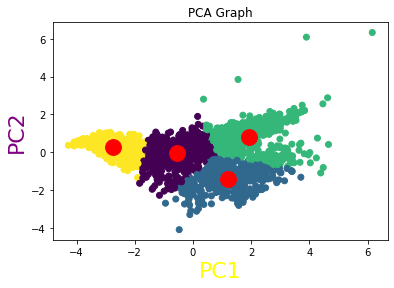

In [29]:
plt.scatter(transformedData[:,0], transformedData[:,1], c=kmeans.labels_)

# Show K-Means centers as red circles
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, alpha=1);

plt.title('PCA Graph')
plt.xlabel('PC1', fontsize=22, color='yellow')
plt.ylabel('PC2', fontsize=22, color='purple')